# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [49]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=";")



In [50]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")

In [51]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [52]:
azdias.shape

(891221, 85)

In [53]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [54]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [ ]:
#first observation: PLZ is Missing

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

**1.1.1.1**

In [55]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')

def rep_missing(x, check_list):
    '''
    This Function replace the mising_value with NaNs
    '''
    x_output=x
    for ele in check_list:
        try:
            miss_value = (float(ele))
        except ValueError:
            miss_value = ele
        if x == miss_value:
            x_output = np.nan
            break
    return x_output
    
#feat_info['missing_or_unknown']
for featurescolumns in azdias.columns.tolist():
    
    misslist = feat_info[feat_info.attribute==featurescolumns]['missing_or_unknown'].values[0]
    azdias[featurescolumns]=azdias[featurescolumns].apply(lambda x: rep_missing(x, misslist))
    
azdias_new=azdias.copy()

In [56]:
azdias_new.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [57]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [58]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Investigate patterns in the amount of missing data in each column.

for column in azdias_new:
    print(azdias_new.columns.get_loc(column), column,"\t","\t","\t","\t",azdias_new[column].isna().sum())

0 AGER_TYP 	 	 	 	 685843
1 ALTERSKATEGORIE_GROB 	 	 	 	 2881
2 ANREDE_KZ 	 	 	 	 0
3 CJT_GESAMTTYP 	 	 	 	 4854
4 FINANZ_MINIMALIST 	 	 	 	 0
5 FINANZ_SPARER 	 	 	 	 0
6 FINANZ_VORSORGER 	 	 	 	 0
7 FINANZ_ANLEGER 	 	 	 	 0
8 FINANZ_UNAUFFAELLIGER 	 	 	 	 0
9 FINANZ_HAUSBAUER 	 	 	 	 0
10 FINANZTYP 	 	 	 	 0
11 GEBURTSJAHR 	 	 	 	 392318
12 GFK_URLAUBERTYP 	 	 	 	 4854
13 GREEN_AVANTGARDE 	 	 	 	 0
14 HEALTH_TYP 	 	 	 	 111196
15 LP_LEBENSPHASE_FEIN 	 	 	 	 97632
16 LP_LEBENSPHASE_GROB 	 	 	 	 94572
17 LP_FAMILIE_FEIN 	 	 	 	 77792
18 LP_FAMILIE_GROB 	 	 	 	 77792
19 LP_STATUS_FEIN 	 	 	 	 4854
20 LP_STATUS_GROB 	 	 	 	 4854
21 NATIONALITAET_KZ 	 	 	 	 108315
22 PRAEGENDE_JUGENDJAHRE 	 	 	 	 108164
23 RETOURTYP_BK_S 	 	 	 	 4854
24 SEMIO_SOZ 	 	 	 	 0
25 SEMIO_FAM 	 	 	 	 0
26 SEMIO_REL 	 	 	 	 0
27 SEMIO_MAT 	 	 	 	 0
28 SEMIO_VERT 	 	 	 	 0
29 SEMIO_LUST 	 	 	 	 0
30 SEMIO_ERL 	 	 	 	 0
31 SEMIO_KULT 	 	 	 	 0
32 SEMIO_RAT 	 	 	 	 0
33 SEMIO_KRIT 	 	 	 	 0
34 SEMIO_DOM 	 	 	 	 0
35 

**1.1.2.1**

In [59]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Drop every columns which has more than 100,000 NaNs (except 'PRAEGENDE_JUGENDJAHRE' since this column needs special treatment)
cols = [0,11,14,21,38,40,41,43,47,48,60,61,62,63,64,65,70,71,73,74,75,76,77,78,79,80,81]
azdias_new.drop(azdias_new.columns[cols],axis=1,inplace=True)
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015,CAMEO_INTL_2015,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,8A,51,6.0,3.0,8.0,3.0,3.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,4C,24,2.0,4.0,4.0,4.0,2.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2A,12,4.0,2.0,6.0,4.0,1.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,6B,43,2.0,5.0,1.0,5.0,5.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

There is systematically missing data: Columns which are related to each other seems to have the same number of missing values. (i.e. the "PLZ8_..." Columns with 116,515 NaNs). But there are columns without a pattern as well (i.e. ALTERSKATEGORIE_GROB).

I removed every columns with more than 100,000 NaNs since more than 10% (100,000 of 891,211) of values are missing (except 'PRAEGENDE_JUGENDJAHRE' since this column needs special treatment)

Specifically, I removed AGER_TYP, GEBURTSJAHR, HEALTH_TYP, NATIONALITAET_KZ, SHOPPER_TYP, TITEL_KZ, VERS_TYP, ALTER_HH, KK_KUNDENTYP, W_KEIT_KIND_HH, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_BAUMAX, KBA05_GBZ, KKK, MOBI_REGIO, REGIOTYP, KBA13_ANZAHL_PKW, PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ and PLZ8_GBZ







#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

**1.1.3.1**

In [60]:
azdias_new.shape

(891221, 58)

In [61]:
#Dictionary with row index and count of missing values
row_missing_values = {}
for index, row in azdias_new.iterrows():
    #print(index)
    i = azdias_new.iloc[index, : ].isna().sum()
    row_missing_values[index] = i 
    #print(azdias_new.iloc[index, : ].isna().sum())
    
len(row_missing_values)

891221

In [62]:
df_2 = pd.DataFrame([row_missing_values])
print(df_2)

   0       1       2       3       4       5       6       7       8       \
0      22       0       0       4       0       0       0       0       0   

   9        ...    891211  891212  891213  891214  891215  891216  891217  \
0       0   ...         0       0       0       0       0       3       0   

   891218  891219  891220  
0       4       0       0  

[1 rows x 891221 columns]


In [63]:
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,891211,891212,891213,891214,891215,891216,891217,891218,891219,891220
0,22,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,3,0,4,0,0


In [64]:
#Transpose DF to see all distinct values (# Missing rows)
df_3 = df_2.T
df_3.head()

,0
0,22
1,0
2,0
3,4
4,0


In [65]:
# 22 missing values seems to be the treshold
# Inspect an Example which has 22 missing values: Print every column entry of the first row
azdias_new.iloc[0, : ]

ALTERSKATEGORIE_GROB       2
ANREDE_KZ                  1
CJT_GESAMTTYP              2
FINANZ_MINIMALIST          3
FINANZ_SPARER              4
FINANZ_VORSORGER           3
FINANZ_ANLEGER             5
FINANZ_UNAUFFAELLIGER      5
FINANZ_HAUSBAUER           3
FINANZTYP                  4
GFK_URLAUBERTYP           10
GREEN_AVANTGARDE           0
LP_LEBENSPHASE_FEIN       15
LP_LEBENSPHASE_GROB        4
LP_FAMILIE_FEIN            2
LP_FAMILIE_GROB            2
LP_STATUS_FEIN             1
LP_STATUS_GROB             1
PRAEGENDE_JUGENDJAHRE    NaN
RETOURTYP_BK_S             5
SEMIO_SOZ                  2
SEMIO_FAM                  6
SEMIO_REL                  7
SEMIO_MAT                  5
SEMIO_VERT                 1
SEMIO_LUST                 5
SEMIO_ERL                  3
SEMIO_KULT                 3
SEMIO_RAT                  4
SEMIO_KRIT                 7
SEMIO_DOM                  6
SEMIO_KAEM                 6
SEMIO_PFLICHT              5
SEMIO_TRADV                3
SOHO_KZ       

In [66]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_per_row =azdias_new.isnull().sum(axis=1)

less_missing = azdias_new.iloc[(missing_per_row[missing_per_row<22].index),:]
more_missing = azdias_new.iloc[(missing_per_row[missing_per_row>=22].index),:]

In [67]:
less_missing.shape

(817619, 58)

In [68]:
more_missing.shape

(73602, 58)

In [69]:
less_missing.to_csv('less_missing_2.csv', index = False)

In [70]:
more_missing.to_csv('more_missing_2.csv', index = False)

In [71]:
azdias_new.to_csv('full_2.csv', index = False)

In [3]:
azdias_new = pd.read_csv('full_2.csv')
more_missing = pd.read_csv('more_missing_2.csv')
less_missing = pd.read_csv('less_missing_2.csv')
less_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015,CAMEO_INTL_2015,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,8A,51.0,6.0,3.0,8.0,3.0,3.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,4C,24.0,2.0,4.0,4.0,4.0,2.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2A,12.0,4.0,2.0,6.0,4.0,1.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,6B,43.0,2.0,5.0,1.0,5.0,5.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,8C,54.0,6.0,2.0,7.0,4.0,1.0,2.0,3.0,3.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

There is a clear distinction between rows with no or few missing values and those with many. One can observe that those rows have always missing values in the same columns. Especially the columns at the right end of the table (i.e. ANZ_HAUSHALTE_AKTIV) have missing values and these columns are related to one another (Data about Housing and the residential environment). Maybe these individuals did not want to answer housing related questions. 

Important: There are still NaN-Values in the Dataset, I am going to solve this issue later

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [4]:
#Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
#Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.
#perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each
#you will create a new data frame with only the selected and engineered columns.


In [5]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")

In [72]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [73]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [74]:
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [75]:
#Inspect Values and Value Counts of each Categorical-Value-Column which still exists in the Dataset
Column_list_categorical = list(feat_info[feat_info['type'] == 'categorical'].attribute)

for column in Column_list_categorical:
    try:
        print(less_missing[column].value_counts())
    except:
        pass

2    426621
1    390998
Name: ANREDE_KZ, dtype: int64
4.0    203619
3.0    150932
2.0    144313
5.0    113550
6.0    104730
1.0     95721
Name: CJT_GESAMTTYP, dtype: int64
6    290360
1    199562
2    110831
5    106435
4     57118
3     53313
Name: FINANZTYP, dtype: int64
12.0    133931
10.0    105317
8.0      84929
11.0     77062
5.0      72251
4.0      61730
9.0      58613
3.0      54233
1.0      51678
2.0      45220
7.0      41627
6.0      26274
Name: GFK_URLAUBERTYP, dtype: int64
0    642394
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     412875
10.0    132045
2.0     100979
11.0     49742
8.0      22264
7.0      20042
4.0      11897
5.0      11465
9.0      10706
6.0       8698
3.0       4795
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    412875
5.0    192493
2.0    100979
4.0     51004
3.0     28157
Name: LP_FAMILIE_GROB, dtype: int64
1.0     212142
9.0     138739
2.0     114631
10.0    113923
4.0      75676
3.0      71416
6.0      29549
5.0      28199
8.0      19147
7.0    

In [ ]:
# 'CAMEO_DEU_2015' has to many different values, so get_dummies is not appropriate

In [76]:
#Inspect Values and Value Counts of each Categorical-Value-Column which still exists in the Dataset
Column_list_mixed = list(feat_info[feat_info['type'] == 'mixed'].attribute)

for column in Column_list_mixed:
    try:
        print(less_missing[column].value_counts())
    except:
        pass

1.0     60455
5.0     53826
6.0     44443
2.0     38168
8.0     29665
11.0    25866
7.0     25633
29.0    25604
13.0    25379
10.0    24943
31.0    22874
12.0    22720
30.0    21640
15.0    19472
3.0     19192
19.0    18923
37.0    17804
4.0     16943
14.0    16817
20.0    16654
32.0    16237
39.0    15480
40.0    14380
16.0    14043
27.0    13999
38.0    13333
35.0    13247
34.0    12651
9.0     12431
21.0    12366
28.0    11820
24.0    11679
25.0    10060
36.0     9850
23.0     8810
22.0     6981
18.0     6929
33.0     5837
17.0     5641
26.0     3446
Name: LP_LEBENSPHASE_FEIN, dtype: int64
2.0     153567
1.0     134758
3.0     111986
12.0     70847
4.0      52649
5.0      48147
9.0      47244
10.0     39111
11.0     31735
8.0      29265
6.0      28157
7.0      21739
Name: LP_LEBENSPHASE_GROB, dtype: int64
14.0    188671
8.0     145961
5.0      86405
10.0     85808
3.0      55190
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21281
4.0      20451


In [ ]:
# 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE' and 'LP_LEBENSPHASE_FEIN' has to many distinct values, so get_dummies is not appropriate, 
# BUT 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' need special treatment so I am going to keep it

**1.2.0**

In [77]:
# Dropping the columns which are not appropriate
# 1. Get index

for column in less_missing:
    print(column, less_missing.columns.get_loc(column))

ALTERSKATEGORIE_GROB 0
ANREDE_KZ 1
CJT_GESAMTTYP 2
FINANZ_MINIMALIST 3
FINANZ_SPARER 4
FINANZ_VORSORGER 5
FINANZ_ANLEGER 6
FINANZ_UNAUFFAELLIGER 7
FINANZ_HAUSBAUER 8
FINANZTYP 9
GFK_URLAUBERTYP 10
GREEN_AVANTGARDE 11
LP_LEBENSPHASE_FEIN 12
LP_LEBENSPHASE_GROB 13
LP_FAMILIE_FEIN 14
LP_FAMILIE_GROB 15
LP_STATUS_FEIN 16
LP_STATUS_GROB 17
PRAEGENDE_JUGENDJAHRE 18
RETOURTYP_BK_S 19
SEMIO_SOZ 20
SEMIO_FAM 21
SEMIO_REL 22
SEMIO_MAT 23
SEMIO_VERT 24
SEMIO_LUST 25
SEMIO_ERL 26
SEMIO_KULT 27
SEMIO_RAT 28
SEMIO_KRIT 29
SEMIO_DOM 30
SEMIO_KAEM 31
SEMIO_PFLICHT 32
SEMIO_TRADV 33
SOHO_KZ 34
ZABEOTYP 35
ANZ_PERSONEN 36
ANZ_TITEL 37
HH_EINKOMMEN_SCORE 38
WOHNDAUER_2008 39
ANZ_HAUSHALTE_AKTIV 40
ANZ_HH_TITEL 41
GEBAEUDETYP 42
KONSUMNAEHE 43
MIN_GEBAEUDEJAHR 44
OST_WEST_KZ 45
WOHNLAGE 46
CAMEO_DEUG_2015 47
CAMEO_DEU_2015 48
CAMEO_INTL_2015 49
BALLRAUM 50
EWDICHTE 51
INNENSTADT 52
GEBAEUDETYP_RASTER 53
ONLINE_AFFINITAET 54
ARBEIT 55
ORTSGR_KLS9 56
RELAT_AB 57


In [78]:
# 2. Drop column by index
cols = [12,47]
less_missing.drop(less_missing.columns[cols],axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [79]:
less_missing.shape

(817619, 56)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# I already inspected the values before (see cells above)

# 1. binary variable: every column with type 'mixed' or 'categorical' which is not listed below
# 2. one binary variable that takes on non-numeric values: 'OST_WEST_KZ'
# 3. multi-level categoricals: 'CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','SOHO_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB','WOHNLAGE'
# 4. special treatment for 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE'



**1.2.1.2 & 1.2.1.3**

In [80]:
cat_vars = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','SOHO_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB','WOHNLAGE','OST_WEST_KZ']
cat_vars = list(cat_vars)
print(cat_vars)    

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SOHO_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'OST_WEST_KZ']


In [81]:
# Re-encode categorical variable(s) to be kept in the analysis.

for var in  cat_vars:
    # for each cat add dummy var, drop original column
    try:
        less_missing = pd.concat([less_missing.drop(var, axis=1), pd.get_dummies(less_missing[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    except:
        pass 

In [82]:
less_missing['OST_WEST_KZ_W'].value_counts()

1    629528
0    188091
Name: OST_WEST_KZ_W, dtype: int64

In [83]:
for column in less_missing:
    print(column, less_missing.columns.get_loc(column))

ALTERSKATEGORIE_GROB 0
ANREDE_KZ 1
FINANZ_MINIMALIST 2
FINANZ_SPARER 3
FINANZ_VORSORGER 4
FINANZ_ANLEGER 5
FINANZ_UNAUFFAELLIGER 6
FINANZ_HAUSBAUER 7
GREEN_AVANTGARDE 8
PRAEGENDE_JUGENDJAHRE 9
RETOURTYP_BK_S 10
SEMIO_SOZ 11
SEMIO_FAM 12
SEMIO_REL 13
SEMIO_MAT 14
SEMIO_VERT 15
SEMIO_LUST 16
SEMIO_ERL 17
SEMIO_KULT 18
SEMIO_RAT 19
SEMIO_KRIT 20
SEMIO_DOM 21
SEMIO_KAEM 22
SEMIO_PFLICHT 23
SEMIO_TRADV 24
ANZ_PERSONEN 25
ANZ_TITEL 26
HH_EINKOMMEN_SCORE 27
WOHNDAUER_2008 28
ANZ_HAUSHALTE_AKTIV 29
ANZ_HH_TITEL 30
KONSUMNAEHE 31
MIN_GEBAEUDEJAHR 32
CAMEO_DEU_2015 33
CAMEO_INTL_2015 34
BALLRAUM 35
EWDICHTE 36
INNENSTADT 37
GEBAEUDETYP_RASTER 38
ONLINE_AFFINITAET 39
ARBEIT 40
ORTSGR_KLS9 41
RELAT_AB 42
CJT_GESAMTTYP_2.0 43
CJT_GESAMTTYP_3.0 44
CJT_GESAMTTYP_4.0 45
CJT_GESAMTTYP_5.0 46
CJT_GESAMTTYP_6.0 47
FINANZTYP_2 48
FINANZTYP_3 49
FINANZTYP_4 50
FINANZTYP_5 51
FINANZTYP_6 52
GFK_URLAUBERTYP_2.0 53
GFK_URLAUBERTYP_3.0 54
GFK_URLAUBERTYP_4.0 55
GFK_URLAUBERTYP_5.0 56
GFK_URLAUBERTYP_6.0 57
GFK

In [84]:
less_missing.to_csv('less_missing_after_get_dummies_2.csv', index = False)

In [4]:
less_missing = pd.read_csv('less_missing_after_get_dummies_2.csv')

#### Discussion 1.2.1: Re-Encode Categorical Features

1. Dropping the columns which are not appropriate ('CAMEO_DEU_2015' and 'LP_LEBENSPHASE_FEIN')
2. Keeping all other colums
3. Performing "Get_Dummies" on the column that takes on non-numeric value ('OST_WEST_KZ') as well as on every multi-level-categoricals-column (i.e. 'GFK_URLAUBERTYP')
4. Do not perform "Get_Dummies" on 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE'


**1.2.1.4 will be processed in 1.2.2**

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [104]:
#Look at an example where less than 22 values are missing
azdias_new.iloc[12, : ]

ALTERSKATEGORIE_GROB        3
ANREDE_KZ                   1
CJT_GESAMTTYP               6
FINANZ_MINIMALIST           5
FINANZ_SPARER               3
FINANZ_VORSORGER            4
FINANZ_ANLEGER              2
FINANZ_UNAUFFAELLIGER       4
FINANZ_HAUSBAUER            1
FINANZTYP                   3
GFK_URLAUBERTYP            10
GREEN_AVANTGARDE            0
LP_LEBENSPHASE_FEIN        23
LP_LEBENSPHASE_GROB         6
LP_FAMILIE_FEIN             5
LP_FAMILIE_GROB             3
LP_STATUS_FEIN              9
LP_STATUS_GROB              4
PRAEGENDE_JUGENDJAHRE       8
RETOURTYP_BK_S              5
SEMIO_SOZ                   3
SEMIO_FAM                   4
SEMIO_REL                   4
SEMIO_MAT                   6
SEMIO_VERT                  7
SEMIO_LUST                  6
SEMIO_ERL                   4
SEMIO_KULT                  5
SEMIO_RAT                   5
SEMIO_KRIT                  5
SEMIO_DOM                   2
SEMIO_KAEM                  4
SEMIO_PFLICHT               4
SEMIO_TRAD

In [119]:
less_missing['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188671
8.0     145961
5.0      86405
10.0     85808
3.0      55190
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21281
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [2]:
less_missing = pd.read_csv('less_missing_after_get_dummies_3.csv')

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#Add new column and fill with zeros
less_missing['PRAEGENDE_JUGENDJAHRE_mainstream'] = 0

In [ ]:
#Mainstream
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 1.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 3.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 5.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 8.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 10.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 12.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 14.0] = 1
#movement
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 2.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 4.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 6.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 7.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 9.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 11.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 13.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 15.0] = 2

In [3]:
less_missing['PRAEGENDE_JUGENDJAHRE_mainstream'].value_counts()

1    607762
2    175225
0     34632
Name: PRAEGENDE_JUGENDJAHRE_mainstream, dtype: int64

In [8]:
#Decade encoding
#Add new column and fill with zeros
less_missing['PRAEGENDE_JUGENDJAHRE_decade'] = 0
less_missing['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

0    817619
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [9]:

#40s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 1.0] = 1
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 2.0] = 1
#50s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 3.0] = 2
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 4.0] = 2
#60s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 5.0] = 3
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 6.0] = 3
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 7.0] = 3
#70s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 8.0] = 4
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 9.0] = 4
#80s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 10.0] = 5
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 11.0] = 5
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 12.0] = 5
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 13.0] = 5
#90s
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 14.0] = 6
less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 15.0] = 6

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ip

In [10]:
less_missing['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

6    231218
4    179531
5    151770
3    116067
2     75641
0     34632
1     28760
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [19]:
#less_missing.drop('CAMEO_INTL_2015_wealth',axis=1,inplace=True)

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#WEALTH encoding
#Add new column and fill with zeros
less_missing['CAMEO_INTL_2015_wealth'] = 0
less_missing['CAMEO_INTL_2015_wealth'].value_counts()

0    817619
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [22]:
#Wealthy
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 11] = 5
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 12] = 5
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 13] = 5
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 14] = 5
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 15] = 5
# Prosperous
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 21] = 4
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 22] = 4
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 23] = 4
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 24] = 4
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 25] = 4
#Comfortable
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 31] = 3
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 32] = 3
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 33] = 3
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 34] = 3
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 35] = 3
#Less Affluent
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 41] = 2
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 42] = 2
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 43] = 2
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 44] = 2
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 45] = 2
#Poorer
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 51] = 1
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 52] = 1
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 53] = 1
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 54] = 1
less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 55] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ip

In [24]:
less_missing['CAMEO_INTL_2015_wealth'].value_counts()

1    223582
4    190691
2    189960
5    119443
3     68193
0     25750
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [25]:
#life stage
#Add new column and fill with zeros
less_missing['CAMEO_INTL_2015_life_stage'] = 0
less_missing['CAMEO_INTL_2015_life_stage'].value_counts()

0    817619
Name: CAMEO_INTL_2015_life_stage, dtype: int64

In [26]:
#Wealthy
#Pre-Family Couples & Singles
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 11] = 1
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 21] = 1
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 31] = 1
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 41] = 1
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 51] = 1
#Young Couples With Children
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 12] = 2
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 22] = 2
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 32] = 2
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 42] = 2
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 52] = 2
#Families With School Age Children
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 13] = 3
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 23] = 3
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 33] = 3
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 43] = 3
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 53] = 3
#Older Families &  Mature Couples
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 14] = 4
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 24] = 4
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 34] = 4
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 44] = 4
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 54] = 4
#Elders In Retirement
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 15] = 5
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 25] = 5
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 35] = 5
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 45] = 5
less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 55] = 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages

In [27]:
less_missing['CAMEO_INTL_2015_life_stage'].value_counts()

1    245054
4    232777
3    119693
5    117045
2     77300
0     25750
Name: CAMEO_INTL_2015_life_stage, dtype: int64

In [28]:
less_missing.to_csv('less_missing_after_get_dummies_4.csv', index = False)

In [29]:
#Drop original columns
less_missing.drop('CAMEO_INTL_2015',axis=1,inplace=True)
less_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [30]:
for column in less_missing:
    print(column, less_missing.columns.get_loc(column))

ALTERSKATEGORIE_GROB 0
ANREDE_KZ 1
FINANZ_MINIMALIST 2
FINANZ_SPARER 3
FINANZ_VORSORGER 4
FINANZ_ANLEGER 5
FINANZ_UNAUFFAELLIGER 6
FINANZ_HAUSBAUER 7
GREEN_AVANTGARDE 8
RETOURTYP_BK_S 9
SEMIO_SOZ 10
SEMIO_FAM 11
SEMIO_REL 12
SEMIO_MAT 13
SEMIO_VERT 14
SEMIO_LUST 15
SEMIO_ERL 16
SEMIO_KULT 17
SEMIO_RAT 18
SEMIO_KRIT 19
SEMIO_DOM 20
SEMIO_KAEM 21
SEMIO_PFLICHT 22
SEMIO_TRADV 23
ANZ_PERSONEN 24
ANZ_TITEL 25
HH_EINKOMMEN_SCORE 26
WOHNDAUER_2008 27
ANZ_HAUSHALTE_AKTIV 28
ANZ_HH_TITEL 29
KONSUMNAEHE 30
MIN_GEBAEUDEJAHR 31
CAMEO_DEU_2015 32
BALLRAUM 33
EWDICHTE 34
INNENSTADT 35
GEBAEUDETYP_RASTER 36
ONLINE_AFFINITAET 37
ARBEIT 38
ORTSGR_KLS9 39
RELAT_AB 40
CJT_GESAMTTYP_2.0 41
CJT_GESAMTTYP_3.0 42
CJT_GESAMTTYP_4.0 43
CJT_GESAMTTYP_5.0 44
CJT_GESAMTTYP_6.0 45
FINANZTYP_2 46
FINANZTYP_3 47
FINANZTYP_4 48
FINANZTYP_5 49
FINANZTYP_6 50
GFK_URLAUBERTYP_2.0 51
GFK_URLAUBERTYP_3.0 52
GFK_URLAUBERTYP_4.0 53
GFK_URLAUBERTYP_5.0 54
GFK_URLAUBERTYP_6.0 55
GFK_URLAUBERTYP_7.0 56
GFK_URLAUBERTYP_8.0 57
G

In [31]:
less_missing.to_csv('less_missing_after_get_dummies_5.csv', index = False)

#### Discussion 1.2.2: Engineer Mixed-Type Features

As recommended I kept the columns which need special treatment ('PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015') and engineered them in the following way:

For 'PRAEGENDE_JUGENDJAHRE' I created to new columns: one for the movement and on for the decade: 

    'PRAEGENDE_JUGENDJAHRE_mainstream' --> binary variable,
    
    0 = other (NaN)
    1 = mainstream movement
    2 = Avantgarde movement
    
    'PRAEGENDE_JUGENDJAHRE_decade', ascending order:

    0 = other (NaN)
    1 = 40s
    2 = 50s
    3 = 60s
    4 = 70s
    5 = 80s
    6 = 90s

For 'CAMEO_INTL_2015' I created to new columns: one for the wealth and on for the life stage: 

    'CAMEO_INTL_2015_wealth', ascending order:

    0 = other (NaN)
    1 = Poorer
    2 = Less Affluent
    3 = Comfortable
    4 = Prosperous
    5 =  Wealthy

    'CAMEO_INTL_2015_life_stage', ascending order:

    0 = other (NaN)
    1 = Pre-Family Couples & Singles
    2 = Young Couples With Children
    3 = Families With School Age Children
    4 = Older Families &  Mature Couples
    5 = Elders In Retirement

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

--> **I already dropped the original Columns**

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Count NaN (Column Name, Index, #NaN)

for column in less_missing:
    print(column, less_missing[column].isna().sum(), less_missing.columns.get_loc(column))

ALTERSKATEGORIE_GROB 2881 0
ANREDE_KZ 0 1
FINANZ_MINIMALIST 0 2
FINANZ_SPARER 0 3
FINANZ_VORSORGER 0 4
FINANZ_ANLEGER 0 5
FINANZ_UNAUFFAELLIGER 0 6
FINANZ_HAUSBAUER 0 7
GREEN_AVANTGARDE 0 8
RETOURTYP_BK_S 4754 9
SEMIO_SOZ 0 10
SEMIO_FAM 0 11
SEMIO_REL 0 12
SEMIO_MAT 0 13
SEMIO_VERT 0 14
SEMIO_LUST 0 15
SEMIO_ERL 0 16
SEMIO_KULT 0 17
SEMIO_RAT 0 18
SEMIO_KRIT 0 19
SEMIO_DOM 0 20
SEMIO_KAEM 0 21
SEMIO_PFLICHT 0 22
SEMIO_TRADV 0 23
ANZ_PERSONEN 0 24
ANZ_TITEL 0 25
HH_EINKOMMEN_SCORE 18248 26
WOHNDAUER_2008 0 27
ANZ_HAUSHALTE_AKTIV 26009 28
ANZ_HH_TITEL 23406 29
KONSUMNAEHE 466 30
MIN_GEBAEUDEJAHR 19546 31
CAMEO_DEU_2015 25750 32
BALLRAUM 20138 33
EWDICHTE 20138 34
INNENSTADT 20138 35
GEBAEUDETYP_RASTER 19553 36
ONLINE_AFFINITAET 4754 37
ARBEIT 23773 38
ORTSGR_KLS9 23672 39
RELAT_AB 23773 40
CJT_GESAMTTYP_2.0 0 41
CJT_GESAMTTYP_3.0 0 42
CJT_GESAMTTYP_4.0 0 43
CJT_GESAMTTYP_5.0 0 44
CJT_GESAMTTYP_6.0 0 45
FINANZTYP_2 0 46
FINANZTYP_3 0 47
FINANZTYP_4 0 48
FINANZTYP_5 0 49
FINANZTYP_6 0 50
G

In [34]:
#feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")

In [ ]:
#Column Name and Index with >0 NaN Values

#ALTERSKATEGORIE_GROB 0 ordinal
#RETOURTYP_BK_S 9 ordinal
#HH_EINKOMMEN_SCORE 26 ordinal
#ANZ_HAUSHALTE_AKTIV 28 numeric
#ANZ_HH_TITEL 29 numeric
#KONSUMNAEHE 30 ordinal
#MIN_GEBAEUDEJAHR 31 numeric
#CAMEO_DEU_2015 32 categorical
#BALLRAUM 33 ordinal
#EWDICHTE 34 ordinal
#INNENSTADT 35 ordinal
#GEBAEUDETYP_RASTER 36 ordinal
#ONLINE_AFFINITAET 37 ordinal
#ARBEIT 38 ordinal
#ORTSGR_KLS9 39 ordinal
#RELAT_AB 40 ordinal


**Step 1.2.3.1: Categorical**

In [37]:
# 1. categorical

less_missing['CAMEO_DEU_2015'].value_counts(dropna=False)

6B     56672
8A     52438
4C     47819
2D     35074
3C     34769
7A     34399
3D     34307
8B     33434
4A     33155
8C     30993
9D     28593
9B     27676
NaN    25750
9C     24987
7B     24503
9A     20542
2C     19422
8D     17576
6E     16107
2B     15486
5D     14943
6C     14820
2A     13249
5A     12214
1D     11909
1A     10850
3A     10543
5B     10354
5C      9935
7C      9065
4B      9047
4D      8570
3B      7160
6A      6810
9E      6379
6D      6073
6F      5392
7D      5333
4E      5321
1E      5065
7E      4633
1C      4317
5F      4283
1B      4071
5E      3581
Name: CAMEO_DEU_2015, dtype: int64

In [43]:
# Encode NaN-Values as a new, distinct value (i.e. 'ZZ')

less_missing['CAMEO_DEU_2015'].fillna(value='ZZ', inplace=True)
less_missing['CAMEO_DEU_2015'].value_counts(dropna=False)

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
ZZ    25750
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

**Step 1.2.3.2: Ordinal**

In [44]:
less_missing['ALTERSKATEGORIE_GROB'].value_counts(dropna=False)

 3.0    318024
 4.0    228480
 2.0    140610
 1.0    127624
NaN       2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [45]:
less_missing['ALTERSKATEGORIE_GROB'].fillna(value=0.0, inplace=True)
less_missing['ALTERSKATEGORIE_GROB'].value_counts(dropna=False)

3.0    318024
4.0    228480
2.0    140610
1.0    127624
0.0      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [46]:
less_missing['RETOURTYP_BK_S'].value_counts(dropna=False)

 5.0    288228
 3.0    179930
 4.0    126578
 1.0    125561
 2.0     92568
NaN       4754
Name: RETOURTYP_BK_S, dtype: int64

In [47]:
less_missing['RETOURTYP_BK_S'].fillna(value=0.0, inplace=True)
less_missing['RETOURTYP_BK_S'].value_counts(dropna=False)

5.0    288228
3.0    179930
4.0    126578
1.0    125561
2.0     92568
0.0      4754
Name: RETOURTYP_BK_S, dtype: int64

In [48]:
less_missing['HH_EINKOMMEN_SCORE'].value_counts(dropna=False)

 6.0    252775
 5.0    201482
 4.0    139762
 3.0     84804
 2.0     67316
 1.0     53232
NaN      18248
Name: HH_EINKOMMEN_SCORE, dtype: int64

In [49]:
less_missing['HH_EINKOMMEN_SCORE'].fillna(value=0.0, inplace=True)
less_missing['HH_EINKOMMEN_SCORE'].value_counts(dropna=False)

6.0    252775
5.0    201482
4.0    139762
3.0     84804
2.0     67316
1.0     53232
0.0     18248
Name: HH_EINKOMMEN_SCORE, dtype: int64

In [50]:
less_missing['KONSUMNAEHE'].value_counts(dropna=False)

 1.0    193715
 3.0    171105
 5.0    153519
 2.0    134645
 4.0    133311
 6.0     26620
 7.0      4238
NaN        466
Name: KONSUMNAEHE, dtype: int64

In [51]:
less_missing['KONSUMNAEHE'].fillna(value=0.0, inplace=True)
less_missing['KONSUMNAEHE'].value_counts(dropna=False)

1.0    193715
3.0    171105
5.0    153519
2.0    134645
4.0    133311
6.0     26620
7.0      4238
0.0       466
Name: KONSUMNAEHE, dtype: int64

In [52]:
less_missing['BALLRAUM'].value_counts(dropna=False)

 6.0    255093
 1.0    151782
 2.0    104521
 7.0     99039
 3.0     73277
 4.0     61358
 5.0     52411
NaN      20138
Name: BALLRAUM, dtype: int64

In [53]:
less_missing['BALLRAUM'].fillna(value=0.0, inplace=True)
less_missing['BALLRAUM'].value_counts(dropna=False)

6.0    255093
1.0    151782
2.0    104521
7.0     99039
3.0     73277
4.0     61358
5.0     52411
0.0     20138
Name: BALLRAUM, dtype: int64

In [54]:
less_missing['EWDICHTE'].value_counts(dropna=False)

 6.0    201009
 5.0    161209
 2.0    139087
 4.0    130716
 1.0     84051
 3.0     81409
NaN      20138
Name: EWDICHTE, dtype: int64

In [55]:
less_missing['EWDICHTE'].fillna(value=0.0, inplace=True)
less_missing['EWDICHTE'].value_counts(dropna=False)

6.0    201009
5.0    161209
2.0    139087
4.0    130716
1.0     84051
3.0     81409
0.0     20138
Name: EWDICHTE, dtype: int64

In [56]:
less_missing['INNENSTADT'].value_counts(dropna=False)

 5.0    147626
 4.0    134067
 6.0    111679
 2.0    109048
 3.0     92818
 8.0     82870
 7.0     67463
 1.0     51910
NaN      20138
Name: INNENSTADT, dtype: int64

In [57]:
less_missing['INNENSTADT'].fillna(value=0.0, inplace=True)
less_missing['INNENSTADT'].value_counts(dropna=False)

5.0    147626
4.0    134067
6.0    111679
2.0    109048
3.0     92818
8.0     82870
7.0     67463
1.0     51910
0.0     20138
Name: INNENSTADT, dtype: int64

In [58]:
less_missing['GEBAEUDETYP_RASTER'].value_counts(dropna=False)

 4.0    359620
 3.0    205330
 5.0    159217
 2.0     58961
NaN      19553
 1.0     14938
Name: GEBAEUDETYP_RASTER, dtype: int64

In [59]:
less_missing['GEBAEUDETYP_RASTER'].fillna(value=0.0, inplace=True)
less_missing['GEBAEUDETYP_RASTER'].value_counts(dropna=False)

4.0    359620
3.0    205330
5.0    159217
2.0     58961
0.0     19553
1.0     14938
Name: GEBAEUDETYP_RASTER, dtype: int64

In [60]:
less_missing['ONLINE_AFFINITAET'].value_counts(dropna=False)

 4.0    158831
 3.0    157693
 1.0    151763
 2.0    147114
 5.0    133473
 0.0     63991
NaN       4754
Name: ONLINE_AFFINITAET, dtype: int64

In [61]:
less_missing['ONLINE_AFFINITAET'].fillna(value=6.0, inplace=True)
less_missing['ONLINE_AFFINITAET'].value_counts(dropna=False)

4.0    158831
3.0    157693
1.0    151763
2.0    147114
5.0    133473
0.0     63991
6.0      4754
Name: ONLINE_AFFINITAET, dtype: int64

In [62]:
less_missing['ARBEIT'].value_counts(dropna=False)

 4.0    311339
 3.0    254988
 2.0    135662
 1.0     56767
 5.0     35090
NaN      23773
Name: ARBEIT, dtype: int64

In [63]:
less_missing['ARBEIT'].fillna(value=0.0, inplace=True)
less_missing['ARBEIT'].value_counts(dropna=False)

4.0    311339
3.0    254988
2.0    135662
1.0     56767
5.0     35090
0.0     23773
Name: ARBEIT, dtype: int64

In [64]:
less_missing['ORTSGR_KLS9'].value_counts(dropna=False)

 5.0    148096
 4.0    114909
 7.0    102866
 9.0     91879
 3.0     83542
 6.0     75995
 8.0     72709
 2.0     63362
 1.0     40589
NaN      23672
Name: ORTSGR_KLS9, dtype: int64

In [65]:
less_missing['ORTSGR_KLS9'].fillna(value=0.0, inplace=True)
less_missing['ORTSGR_KLS9'].value_counts(dropna=False)

5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
0.0     23672
Name: ORTSGR_KLS9, dtype: int64

In [66]:
less_missing['RELAT_AB'].value_counts(dropna=False)

 3.0    274008
 5.0    174964
 1.0    142907
 2.0    104846
 4.0     97121
NaN      23773
Name: RELAT_AB, dtype: int64

In [67]:
less_missing['RELAT_AB'].fillna(value=0.0, inplace=True)
less_missing['RELAT_AB'].value_counts(dropna=False)

3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
0.0     23773
Name: RELAT_AB, dtype: int64

**Step 1.2.3.3: Numeric**

In [69]:
less_missing.to_csv('less_missing_after_get_dummies_6.csv', index = False)

In [78]:
less_missing = pd.read_csv('less_missing_after_get_dummies_6.csv')

In [79]:
less_missing['ANZ_HAUSHALTE_AKTIV'].value_counts(dropna=False)

 1.0      195957
 2.0      120982
 3.0       62575
 4.0       43213
 5.0       37815
 6.0       36020
 7.0       34526
 8.0       32293
 9.0       29002
NaN        26009
 10.0      25428
 11.0      21965
 12.0      18033
 13.0      15282
 14.0      12625
 15.0      10371
 16.0       8899
 17.0       7292
 18.0       6324
 19.0       5461
 20.0       4674
 21.0       4138
 22.0       3735
 23.0       3243
 24.0       2838
 25.0       2636
 26.0       2342
 27.0       2232
 28.0       2040
 29.0       1963
           ...  
 326.0         4
 250.0         4
 266.0         4
 174.0         4
 260.0         4
 256.0         4
 523.0         4
 255.0         4
 301.0         4
 249.0         4
 515.0         4
 285.0         4
 293.0         3
 224.0         3
 414.0         3
 168.0         3
 272.0         3
 395.0         3
 307.0         3
 244.0         3
 226.0         3
 378.0         3
 404.0         2
 237.0         2
 254.0         2
 213.0         2
 366.0         1
 232.0        

In [80]:
less_missing['ANZ_HAUSHALTE_AKTIV'].fillna((less_missing['ANZ_HAUSHALTE_AKTIV'].mean()).round(0), inplace=True)
less_missing['ANZ_HAUSHALTE_AKTIV'].value_counts(dropna=False)

1.0      195957
2.0      120982
3.0       62575
8.0       58302
4.0       43213
5.0       37815
6.0       36020
7.0       34526
9.0       29002
10.0      25428
11.0      21965
12.0      18033
13.0      15282
14.0      12625
15.0      10371
16.0       8899
17.0       7292
18.0       6324
19.0       5461
20.0       4674
21.0       4138
22.0       3735
23.0       3243
24.0       2838
25.0       2636
26.0       2342
27.0       2232
28.0       2040
29.0       1963
30.0       1821
          ...  
326.0         4
250.0         4
266.0         4
174.0         4
260.0         4
256.0         4
523.0         4
255.0         4
301.0         4
249.0         4
515.0         4
285.0         4
293.0         3
224.0         3
414.0         3
168.0         3
272.0         3
395.0         3
307.0         3
244.0         3
226.0         3
378.0         3
404.0         2
237.0         2
254.0         2
213.0         2
366.0         1
232.0         1
536.0         1
220.0         1
Name: ANZ_HAUSHALTE_AKTI

In [81]:
less_missing['ANZ_HH_TITEL'].value_counts(dropna=False)

 0.0     770244
NaN       23406
 1.0      20157
 2.0       2459
 3.0        585
 4.0        232
 5.0        117
 6.0        106
 8.0         68
 7.0         65
 9.0         34
 13.0        29
 12.0        22
 11.0        22
 14.0        16
 10.0        16
 17.0        13
 20.0         9
 15.0         7
 18.0         6
 16.0         3
 23.0         3
Name: ANZ_HH_TITEL, dtype: int64

In [82]:
less_missing['ANZ_HH_TITEL'].fillna((less_missing['ANZ_HH_TITEL'].mean()).round(0), inplace=True)
less_missing['ANZ_HH_TITEL'].value_counts(dropna=False)

0.0     793650
1.0      20157
2.0       2459
3.0        585
4.0        232
5.0        117
6.0        106
8.0         68
7.0         65
9.0         34
13.0        29
12.0        22
11.0        22
14.0        16
10.0        16
17.0        13
20.0         9
15.0         7
18.0         6
16.0         3
23.0         3
Name: ANZ_HH_TITEL, dtype: int64

In [83]:
less_missing['MIN_GEBAEUDEJAHR'].value_counts(dropna=False)

 1992.0    568776
 1994.0     78835
 1993.0     25488
 1995.0     25464
NaN         19546
 1996.0     16611
 1997.0     14464
 2000.0      7382
 2001.0      5877
 1991.0      5811
 2005.0      5553
 1999.0      4413
 1990.0      4408
 2002.0      4216
 1998.0      4097
 2003.0      3356
 2004.0      2935
 2008.0      2197
 2007.0      2156
 1989.0      2046
 2009.0      2016
 2006.0      1984
 2011.0      1903
 2012.0      1861
 2010.0      1410
 2013.0      1230
 1988.0      1027
 2014.0      1001
 2015.0       717
 1987.0       470
 2016.0       128
 1986.0       125
 1985.0       116
Name: MIN_GEBAEUDEJAHR, dtype: int64

In [84]:
less_missing['MIN_GEBAEUDEJAHR'].fillna((less_missing['MIN_GEBAEUDEJAHR'].mean()).round(0), inplace=True)
less_missing['MIN_GEBAEUDEJAHR'].value_counts(dropna=False)

1992.0    568776
1994.0     78835
1993.0     45034
1995.0     25464
1996.0     16611
1997.0     14464
2000.0      7382
2001.0      5877
1991.0      5811
2005.0      5553
1999.0      4413
1990.0      4408
2002.0      4216
1998.0      4097
2003.0      3356
2004.0      2935
2008.0      2197
2007.0      2156
1989.0      2046
2009.0      2016
2006.0      1984
2011.0      1903
2012.0      1861
2010.0      1410
2013.0      1230
1988.0      1027
2014.0      1001
2015.0       717
1987.0       470
2016.0       128
1986.0       125
1985.0       116
Name: MIN_GEBAEUDEJAHR, dtype: int64

In [88]:
#Count #NaN in each Column (Column Name, Index, #NaN)

for column in less_missing:
    print(column, less_missing[column].isna().sum(), less_missing.columns.get_loc(column))

ALTERSKATEGORIE_GROB 0 0
ANREDE_KZ 0 1
FINANZ_MINIMALIST 0 2
FINANZ_SPARER 0 3
FINANZ_VORSORGER 0 4
FINANZ_ANLEGER 0 5
FINANZ_UNAUFFAELLIGER 0 6
FINANZ_HAUSBAUER 0 7
GREEN_AVANTGARDE 0 8
RETOURTYP_BK_S 0 9
SEMIO_SOZ 0 10
SEMIO_FAM 0 11
SEMIO_REL 0 12
SEMIO_MAT 0 13
SEMIO_VERT 0 14
SEMIO_LUST 0 15
SEMIO_ERL 0 16
SEMIO_KULT 0 17
SEMIO_RAT 0 18
SEMIO_KRIT 0 19
SEMIO_DOM 0 20
SEMIO_KAEM 0 21
SEMIO_PFLICHT 0 22
SEMIO_TRADV 0 23
ANZ_PERSONEN 0 24
ANZ_TITEL 0 25
HH_EINKOMMEN_SCORE 0 26
WOHNDAUER_2008 0 27
ANZ_HAUSHALTE_AKTIV 0 28
ANZ_HH_TITEL 0 29
KONSUMNAEHE 0 30
MIN_GEBAEUDEJAHR 0 31
CAMEO_DEU_2015 0 32
BALLRAUM 0 33
EWDICHTE 0 34
INNENSTADT 0 35
GEBAEUDETYP_RASTER 0 36
ONLINE_AFFINITAET 0 37
ARBEIT 0 38
ORTSGR_KLS9 0 39
RELAT_AB 0 40
CJT_GESAMTTYP_2.0 0 41
CJT_GESAMTTYP_3.0 0 42
CJT_GESAMTTYP_4.0 0 43
CJT_GESAMTTYP_5.0 0 44
CJT_GESAMTTYP_6.0 0 45
FINANZTYP_2 0 46
FINANZTYP_3 0 47
FINANZTYP_4 0 48
FINANZTYP_5 0 49
FINANZTYP_6 0 50
GFK_URLAUBERTYP_2.0 0 51
GFK_URLAUBERTYP_3.0 0 52
GFK_URLAUB

In [85]:
less_missing.to_csv('less_missing_after_get_dummies_7.csv', index = False)

In [20]:
less_missing = pd.read_csv('less_missing_after_get_dummies_7.csv')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # remove selected columns and rows, ...
    # select, re-encode, and engineer column values.
    # Return the cleaned dataframe.
    
    
    #1.1.1.1
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')

    def rep_missing(x, check_list):
        '''
        This Function replace the mising_value with NaNs
        '''
        x_output=x
        for ele in check_list:
            try:
                miss_value = (float(ele))
            except ValueError:
                miss_value = ele
            if x == miss_value:
                x_output = np.nan
                break
        return x_output

    #feat_info['missing_or_unknown']
    for featurescolumns in df.columns.tolist():

        misslist = feat_info[feat_info.attribute==featurescolumns]['missing_or_unknown'].values[0]
        df[featurescolumns]=df[featurescolumns].apply(lambda x: rep_missing(x, misslist))

    df_new=df.copy()    
    
    #1.1.2.1 Drop certain columns (because to many NaN-Values)
    cols = [0,11,14,21,38,40,41,43,47,48,60,61,62,63,64,65,70,71,73,74,75,76,77,78,79,80,81]
    df_new.drop(azdias_new.columns[cols],axis=1,inplace=True)
    
    
    #1.1.3.1 Drop certain rows
    missing_per_row =df_new.isnull().sum(axis=1)

    less_missing = df_new.iloc[(missing_per_row[missing_per_row<22].index),:]
    #more_missing = df_new.iloc[(missing_per_row[missing_per_row>=22].index),:]
    
    #1.2.0 Drop certain columns (because to many distinct Values)
    
    cols = [12,47]
    less_missing.drop(less_missing.columns[cols],axis=1,inplace=True)
    
    #1.2.1.2 & 1.2.1.3 one binary variable that takes on non-numeric values: 'OST_WEST_KZ' & multi-level categoricals: 'CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','SOHO_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB','WOHNLAGE'

    cat_vars = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','SOHO_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB','WOHNLAGE','OST_WEST_KZ']
    cat_vars = list(cat_vars)
    print(cat_vars)    

    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        try:
            less_missing = pd.concat([less_missing.drop(var, axis=1), pd.get_dummies(less_missing[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        except:
            pass     
    
    #1.2.1.4 & 1.2.2 special treatment for 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE'
    
    less_missing['PRAEGENDE_JUGENDJAHRE_mainstream'] = 0

    #Mainstream
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 1.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 3.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 5.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 8.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 10.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 12.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 14.0] = 1
    #movement
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 2.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 4.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 6.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 7.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 9.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 11.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 13.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_mainstream[less_missing['PRAEGENDE_JUGENDJAHRE'] == 15.0] = 2

    less_missing['PRAEGENDE_JUGENDJAHRE_decade'] = 0

    #40s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 1.0] = 1
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 2.0] = 1
    #50s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 3.0] = 2
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 4.0] = 2
    #60s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 5.0] = 3
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 6.0] = 3
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 7.0] = 3
    #70s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 8.0] = 4
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 9.0] = 4
    #80s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 10.0] = 5
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 11.0] = 5
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 12.0] = 5
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 13.0] = 5
    #90s
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 14.0] = 6
    less_missing.PRAEGENDE_JUGENDJAHRE_decade[less_missing['PRAEGENDE_JUGENDJAHRE'] == 15.0] = 6

    less_missing['CAMEO_INTL_2015_wealth'] = 0
    #Wealthy
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 11] = 5
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 12] = 5
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 13] = 5
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 14] = 5
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 15] = 5
    # Prosperous
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 21] = 4
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 22] = 4
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 23] = 4
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 24] = 4
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 25] = 4
    #Comfortable
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 31] = 3
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 32] = 3
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 33] = 3
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 34] = 3
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 35] = 3
    #Less Affluent
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 41] = 2
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 42] = 2
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 43] = 2
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 44] = 2
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 45] = 2
    #Poorer
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 51] = 1
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 52] = 1
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 53] = 1
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 54] = 1
    less_missing.CAMEO_INTL_2015_wealth[less_missing['CAMEO_INTL_2015'] == 55] = 1

    less_missing['CAMEO_INTL_2015_life_stage'] = 0
    #Wealthy
    #Pre-Family Couples & Singles
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 11] = 1
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 21] = 1
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 31] = 1
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 41] = 1
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 51] = 1
    #Young Couples With Children
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 12] = 2
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 22] = 2
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 32] = 2
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 42] = 2
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 52] = 2
    #Families With School Age Children
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 13] = 3
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 23] = 3
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 33] = 3
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 43] = 3
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 53] = 3
    #Older Families &  Mature Couples
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 14] = 4
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 24] = 4
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 34] = 4
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 44] = 4
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 54] = 4
    #Elders In Retirement
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 15] = 5
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 25] = 5
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 35] = 5
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 45] = 5
    less_missing.CAMEO_INTL_2015_life_stage[less_missing['CAMEO_INTL_2015'] == 55] = 5    
    
    less_missing.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    less_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    
    #1.2.3.1
    less_missing['CAMEO_DEU_2015'].fillna(value='ZZ', inplace=True)
    less_missing['CAMEO_DEU_2015'].value_counts(dropna=False)

    #1.2.3.2
    less_missing['ALTERSKATEGORIE_GROB'].fillna(value=0.0, inplace=True)
    less_missing['ALTERSKATEGORIE_GROB'].value_counts(dropna=False)

    less_missing['RETOURTYP_BK_S'].fillna(value=0.0, inplace=True)
    less_missing['RETOURTYP_BK_S'].value_counts(dropna=False)

    less_missing['HH_EINKOMMEN_SCORE'].fillna(value=0.0, inplace=True)
    less_missing['HH_EINKOMMEN_SCORE'].value_counts(dropna=False)

    less_missing['KONSUMNAEHE'].fillna(value=0.0, inplace=True)
    less_missing['KONSUMNAEHE'].value_counts(dropna=False)

    less_missing['BALLRAUM'].fillna(value=0.0, inplace=True)
    less_missing['BALLRAUM'].value_counts(dropna=False)

    less_missing['EWDICHTE'].fillna(value=0.0, inplace=True)
    less_missing['EWDICHTE'].value_counts(dropna=False)

    less_missing['INNENSTADT'].fillna(value=0.0, inplace=True)
    less_missing['INNENSTADT'].value_counts(dropna=False)

    less_missing['GEBAEUDETYP_RASTER'].fillna(value=0.0, inplace=True)
    less_missing['GEBAEUDETYP_RASTER'].value_counts(dropna=False)

    less_missing['ONLINE_AFFINITAET'].fillna(value=6.0, inplace=True)
    less_missing['ONLINE_AFFINITAET'].value_counts(dropna=False)

    less_missing['ARBEIT'].fillna(value=0.0, inplace=True)
    less_missing['ARBEIT'].value_counts(dropna=False)

    less_missing['ORTSGR_KLS9'].fillna(value=0.0, inplace=True)
    less_missing['ORTSGR_KLS9'].value_counts(dropna=False)

    less_missing['RELAT_AB'].fillna(value=0.0, inplace=True)
    less_missing['RELAT_AB'].value_counts(dropna=False)

    #1.2.3.3

    less_missing['ANZ_HAUSHALTE_AKTIV'].fillna((less_missing['ANZ_HAUSHALTE_AKTIV'].mean()).round(0), inplace=True)
    less_missing['ANZ_HAUSHALTE_AKTIV'].value_counts(dropna=False)

    less_missing['ANZ_HH_TITEL'].fillna((less_missing['ANZ_HH_TITEL'].mean()).round(0), inplace=True)
    less_missing['ANZ_HH_TITEL'].value_counts(dropna=False)

    less_missing['MIN_GEBAEUDEJAHR'].fillna((less_missing['MIN_GEBAEUDEJAHR'].mean()).round(0), inplace=True)
    less_missing['MIN_GEBAEUDEJAHR'].value_counts(dropna=False)
    
    
    
    return less_missing

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#I have already done that


In [8]:
less_missing.dtypes.value_counts()

int64      105
float64     18
object       1
dtype: int64

In [15]:
test = less_missing.select_dtypes(include=['object'])
test.head()

,CAMEO_DEU_2015
0,8A
1,4C
2,2A
3,6B
4,8C


In [21]:
less_missing.shape

(817619, 124)

In [22]:
# Apply feature scaling to the general population demographics data.

#Exclude the column with datatype 'string'
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(less_missing.select_dtypes(include=['float', 'int']))

In [23]:
print(X)

[[-1.73252508  0.95733989 -1.50920198 ...,  1.10585796 -1.08770217
  -1.15378812]
 [ 0.20898934  0.95733989 -1.50920198 ...,  1.10585796  0.88793237
   0.78801646]
 [ 1.17974655  0.95733989  0.66639504 ..., -0.08919498  1.54647721
  -0.50651992]
 ..., 
 [-0.76176787  0.95733989 -0.78400298 ...,  1.10585796  0.88793237
   0.78801646]
 [-1.73252508 -1.0445611  -1.50920198 ...,  1.10585796 -1.08770217
  -1.15378812]
 [ 1.17974655 -1.0445611   0.66639504 ..., -1.28424792 -0.42915732
   0.14074827]]


In [17]:
#less_missing_without_CAMEO_DEU_2015 = less_missing.drop('CAMEO_DEU_2015', axis=1)
#less_missing_without_CAMEO_DEU_2015.shape

(817619, 123)

In [18]:
#X_2 = StandardScaler().fit_transform(less_missing_without_CAMEO_DEU_2015)

In [20]:
#print(X_2)

[[-1.73252508  0.95733989 -1.50920198 ...,  1.10585796 -1.08770217
  -1.15378812]
 [ 0.20898934  0.95733989 -1.50920198 ...,  1.10585796  0.88793237
   0.78801646]
 [ 1.17974655  0.95733989  0.66639504 ..., -0.08919498  1.54647721
  -0.50651992]
 ..., 
 [-0.76176787  0.95733989 -0.78400298 ...,  1.10585796  0.88793237
   0.78801646]
 [-1.73252508 -1.0445611  -1.50920198 ...,  1.10585796 -1.08770217
  -1.15378812]
 [ 1.17974655 -1.0445611   0.66639504 ..., -1.28424792 -0.42915732
   0.14074827]]


In [25]:
#X_compare = (X == X_2)
#unique, counts = np.unique(X_compare, return_counts=True)
#dict(zip(unique, counts))

{True: 100567137}

### Discussion 2.1: Apply Feature Scaling

I applied a StandardScaler instance for every column except the one that is of datatype 'object' ('CAMEO_DEU_2015')

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [24]:
from sklearn.decomposition import PCA


def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [7]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [10]:
# Apply PCA to the data.
# set a number of components that is at least half the number of features

pca, X_pca = do_pca(65, X)

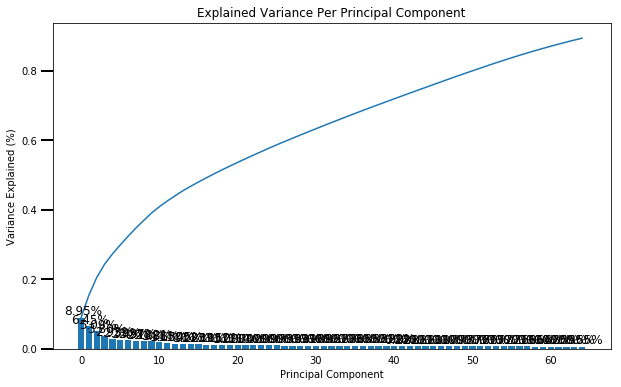

In [11]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

In [12]:
from workspace_utils import active_session
import asyncio

with active_session():
    
     

    loop = asyncio.get_event_loop()
    try:
        loop.run_forever()
    finally:
        loop.close()

KeyboardInterrupt: 

In [25]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Choosing 60 components

pca_60, X_pca_60 = do_pca(60, X)

### Discussion 2.2: Perform Dimensionality Reduction

Even with a number of components that is just a bit above half the number of features, we get an explained variability of ~90%. I am retaining 60 components for the next step of the analysis (explained variability ~85%)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [8]:
def pca_results2(full_dataset, pca, dimension_1):


    def pca_results(full_dataset, pca, dimension_1):
        '''
        Create a DataFrame of the PCA results
        Includes dimension feature weights and explained variance
        Visualizes the PCA results
        '''

        # Dimension indexing
        dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

        # PCA components
        components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
        components.index = dimensions

        # PCA explained variance
        ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        variance_ratios.index = dimensions

        # Create a bar plot visualization
        #fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        #components.plot(ax = ax, kind = 'bar');
        #ax.set_ylabel("Feature Weights")
        #ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        #for i, ev in enumerate(pca.explained_variance_ratio_):
        #    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))


        temp_df = pd.concat([components], axis = 1)


        temp_df = temp_df.T
        temp_df2 = temp_df.rename_axis('Component',axis=0)
        temp_df3 = temp_df2[dimension_1]
        #temp_df4 = temp_df3.sort_values(temp_df3.columns[0], ascending=False)

        #temp_df4 = temp_df3.sort_values(temp_df3.columns[0], ascending=False)
        #temp_df3

        # Return a concatenated DataFrame
        return pd.concat([temp_df3], axis = 1)

    temp_df = pca_results(full_dataset, pca, dimension_1)


    temp_df2 = temp_df.sort_values(temp_df.columns[0], ascending=False)
    return temp_df2

In [30]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#Component 1

temp_df = pca_results2(less_missing.select_dtypes(include=['float', 'int']), pca_60, 'Dimension 1')
temp_df

,Dimension 1
Component,
FINANZ_SPARER,0.2637
SEMIO_REL,0.2305
SEMIO_PFLICHT,0.2257
SEMIO_TRADV,0.2198
FINANZ_UNAUFFAELLIGER,0.2167
PRAEGENDE_JUGENDJAHRE_decade,0.2134
FINANZ_ANLEGER,0.2071
SEMIO_RAT,0.1886
SEMIO_KULT,0.1681


In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#Component 2

temp_df_2 = pca_results2(less_missing.select_dtypes(include=['float', 'int']), pca_60, 'Dimension 2')
temp_df_2

,Dimension 2
Component,
FINANZ_HAUSBAUER,0.2535
HH_EINKOMMEN_SCORE,0.2269
ORTSGR_KLS9,0.1942
EWDICHTE,0.1927
SEMIO_KAEM,0.1623
LP_LEBENSPHASE_GROB_2.0,0.1620
ANZ_HAUSHALTE_AKTIV,0.1486
ARBEIT,0.1417
RELAT_AB,0.1391


In [32]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#Component 3

temp_df_3 = pca_results2(less_missing.select_dtypes(include=['float', 'int']), pca_60, 'Dimension 3')
temp_df_3

,Dimension 3
Component,
SEMIO_VERT,0.2982
SEMIO_FAM,0.2583
SEMIO_SOZ,0.2537
SEMIO_KULT,0.2454
FINANZTYP_5,0.1599
ORTSGR_KLS9,0.1309
EWDICHTE,0.1286
SEMIO_REL,0.1068
RETOURTYP_BK_S,0.1045


In [13]:

# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#Component 3

temp_df_4 = pca_results2(less_missing.select_dtypes(include=['float', 'int']), pca_60, 'Dimension 4')
temp_df_4


,Dimension 4
Component,
GREEN_AVANTGARDE,0.3210
PRAEGENDE_JUGENDJAHRE_mainstream,0.3030
LP_STATUS_FEIN_10.0,0.2825
LP_STATUS_GROB_5.0,0.2825
ORTSGR_KLS9,0.2431
EWDICHTE,0.2365
ANZ_PERSONEN,0.1406
LP_FAMILIE_GROB_5.0,0.1306
RELAT_AB,0.1279


In [34]:
temp_df.to_csv('comp_1.csv', index = False)
temp_df_2.to_csv('comp_2.csv', index = False)
temp_df_3.to_csv('comp_3.csv', index = False)

### Discussion 2.3: Interpret Principal Components

1. Component

-- The Personality type "religious" (SEMIO_REL) and "event-oriented" (SEMIO_ERL) seem to have a negative correlation (features with different signs)<br>
-- The Personality type "religious" (SEMIO_REL) and "dutiful" (SEMIO_PFLICHT) seem to have a positive correlation (features have large weights of the same sign)

2. Component

-- SEMIO_VERT (dreamful) and SEMIO_KAEM (combative attitude) seem to have a negative correlation (features with different signs)

-- LP_STATUS_GROB_4.0 (houseowners) and LP_LEBENSPHASE_GROB_2.0 (single low-income earners of middle age) seem to have a negative correlation (--> low-income earners do not own houses)



3. Component

-- SEMIO_KRIT (critical-minded) / SEMIO_DOM (dominant-minded) / SEMIO_KAEM (combative attitude) on the one side and SEMIO_VERT (dreamful) / SEMIO_FAM (family-minded) / SEMIO_SOZ (socially-minded) on the other side seem to have a negative correlation (features with different signs)
 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [26]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [27]:
X = X_pca_60

In [29]:
from workspace_utils import active_session
#import asyncio


# Over a number of different cluster counts...



possible_k_values = range(5, 60, 50)

# run k-means clustering on the data and...
with active_session():
    errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
    
# compute the average within-cluster distances.
    list = list(zip(possible_k_values, errors_per_k))    
    

MemoryError: 

In [ ]:
list(zip(possible_k_values, errors_per_k))

In [ ]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.